**Projet BAYES: Heart Mixture Model**

Importation des modules nécessaires

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

Importation des données

In [6]:
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
T = x + y                        # Total des observations

Définition des fonctions utilitaires

In [1]:
# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

def log_posterior_alpha(alpha, prior_mu, prior_sd, health_status, y,t,p) :
    log_prior = norm.logpdf(alpha, prior_mu, prior_sd)
    log_lik = 0.0
    for i in range(len(y)) : 
        if health_status[i] == 1 : 
            if y[i] > 0 : 
                return -np.inf
        else : 
            val_i = y[i]*np.log(p) + (t[i]-y[i])*np.log(1-p) 
            if np.isinf(val_i) or np.isnan(val_i):
                return -np.inf
            log_lik += val_i
    return log_prior + log_lik
    
# Fonction log postérieure pour le paramètre delta
def log_posterior_delta(delta, prior_mu, prior_sd, health_status,theta) :
    log_prior = norm.logpdf(delta, prior_mu, prior_sd)
    log_lik = np.sum(health_status) * np.log(theta) + np.sum(1-health_status) * np.log(1-theta)
    return log_prior + log_lik


Algorithme d'inférence MCMC

In [2]:
def heart_mixture_sampler(n_iter,x,y,T) : 
    # Données
    n_individual = len(x)
    
    # Variance des noyaux de propositions
    proposal_sd_alpha = 1
    proposal_sd_delta = 1.5

    # Hyperparamètres des lois a priori
    prior_mu_alpha, prior_sd_alpha = 0, 1000  # Pour logit(p), A REVOIR COMMENT ON CHOISIT NOTRE PRIOR 
    prior_mu_delta, prior_sd_delta = 0, 1000  # Pour logit(theta)

    # Initialisation des chaînes MCMC
    alpha_chain = np.zeros(n_iter)
    delta_chain = np.zeros(n_iter)
    beta_chain = np.zeros(n_iter)
    p_chain = np.zeros(n_iter)
    theta_chain = np.zeros(n_iter)
    health_status = np.zeros(n_individual)
    
    beta_chain[0] = np.exp(alpha_chain[0])
    p_chain[0] = beta_chain[0] / (1 + beta_chain[0])
    theta_chain[0] = inv_logit(delta_chain[0])
    
    # On stocke les ratio d'accpetation 
    acceptance_ratio_alpha = np.zeros(n_iter)
    acceptance_ratio_delta = np.zeros(n_iter)
    
    # On mets à jours les paramètres
    for t in range(1,n_iter) :
        # Mise à jour des variables latentes 
        for i in range(n_individual):
            if y[i] > 0:                 # Pas possible d'être guéri
                health_status[i] = 0
            else:                        # On tire un Bernoulli
            
                numerator = theta_chain[t-1]
                denominator = theta_chain[t-1] + (1 - theta_chain[t-1])*( (1-p_chain[t-1])**T[i] )
                prob_gueri = numerator/denominator
                
                # health_status[i] = 1 si unif < prob_gueri, sinon 0
                if np.random.rand() < prob_gueri:
                    health_status[i] = 1
                else:
                    health_status[i] = 0
                    
        # Mise à jour de alpha via Metropolis-Hastings
        alpha_prop = alpha_chain[t-1] + np.random.normal(0, proposal_sd_alpha) ### A revoir comment on choisit la variance du noyau de proposition 
        p_prop = np.exp(alpha_prop) / (1 + np.exp(alpha_prop))
        
        log_post_prop_alpha = log_posterior_alpha(alpha_prop, prior_mu_alpha, prior_sd_alpha, health_status, y, T, p_prop)
        log_post_curr_alpha = log_posterior_alpha(alpha_chain[t-1], prior_mu_alpha, prior_sd_alpha, health_status, y, T, p_chain[t-1])

        acceptance_ratio = np.exp(log_post_prop_alpha - log_post_curr_alpha)
        acceptance_ratio_alpha[t] = min(1,acceptance_ratio)
        if np.random.rand() < acceptance_ratio_alpha[t]:
            alpha_chain[t] = alpha_prop
            p_chain[t] = p_prop
        else:
            alpha_chain[t] = alpha_chain[t-1]
            p_chain[t] = p_chain[t-1]   
        
        # Mise à jour de delta via Metropolis-Hastings
        delta_prop = delta_chain[t-1] + np.random.normal(0, proposal_sd_delta) ### A revoir comment on choisit la variance du noyau de proposition 
        theta_prop = inv_logit(delta_prop)
        
        log_post_prop_delta = log_posterior_delta(delta_prop, prior_mu_delta, prior_sd_delta, health_status,theta_prop)
        log_post_curr_delta = log_posterior_delta(delta_chain[t-1], prior_mu_delta, prior_sd_delta, health_status,theta_chain[t-1])
        
        acceptance_ratio = np.exp(log_post_prop_delta - log_post_curr_delta)
        acceptance_ratio_delta[t] = min(1,acceptance_ratio)
        
        if np.random.rand() < acceptance_ratio:
            delta_chain[t] = delta_prop
            theta_chain[t] = theta_prop 
        else:
            delta_chain[t] = delta_chain[t-1]
            theta_chain[t] = theta_chain[t-1]
            
        beta_chain[t] = np.exp(alpha_chain[t])
        
    return {
        'alpha_chain': alpha_chain, 
        'delta_chain': delta_chain, 
        'beta_chain': beta_chain, 
        'p_chain': p_chain, 
        'theta_chain': theta_chain, 
        'health_status': health_status, 
        'acceptance_ratio_alpha': acceptance_ratio_alpha,
        'acceptance_ratio_delta': acceptance_ratio_delta
    }

Exécution de l'algorithme

In [7]:
n_iter = 10000
results = heart_mixture_sampler(n_iter, x, y, T)

Visualisation des résultats

Taux d'acceptation moyen (alpha): 0.310
Taux d'acceptation moyen (delta): 0.434


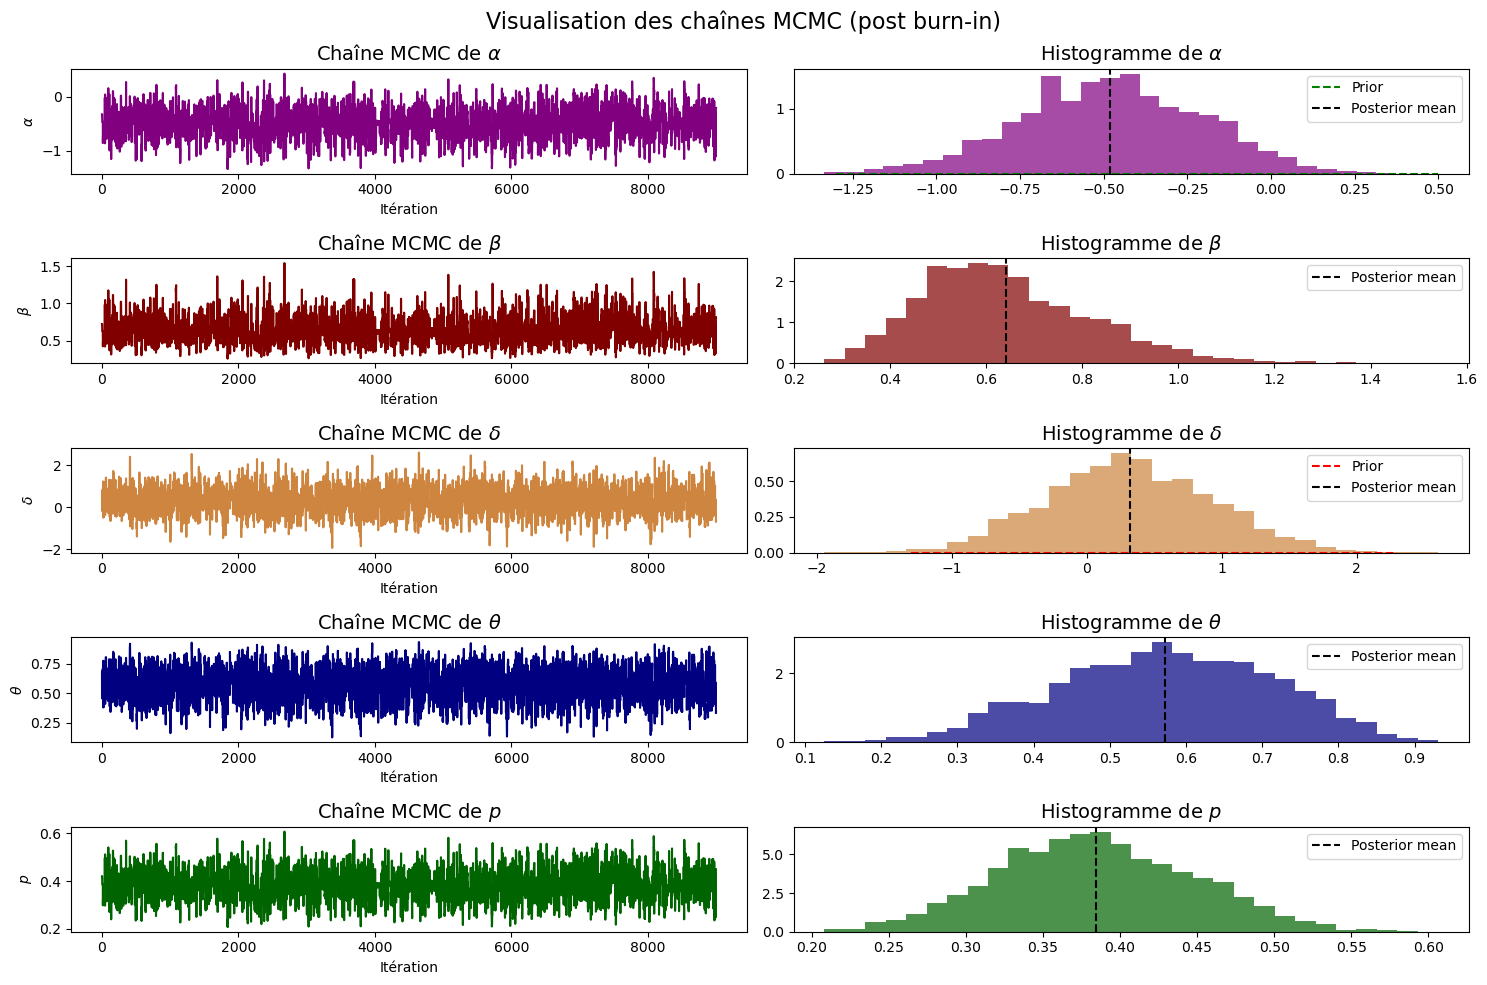

In [ ]:
# Extraction des résultats et suppression phase de burn-in
alpha_chain = results['alpha_chain'][1000:]
delta_chain = results['delta_chain'][1000:]
beta_chain = results['beta_chain'][1000:]
p_chain = results['p_chain'][1000:]
theta_chain = results['theta_chain'][1000:]
acceptance_ratio_alpha = results['acceptance_ratio_alpha']
acceptance_ratio_delta = results['acceptance_ratio_delta']

# Affichage des résultats numériques des taux d'acceptation
print(f"Taux d'acceptation moyen (alpha): {np.mean(acceptance_ratio_alpha):.3f}")
print(f"Taux d'acceptation moyen (delta): {np.mean(acceptance_ratio_delta):.3f}")

# Visualisation des chaînes MCMC (p, theta, beta)
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
fig.suptitle('Visualisation des chaînes MCMC (post burn-in)', fontsize=16)

# Chaîne de alpha
axes[0,0].plot(alpha_chain, color='purple')
axes[0,0].set_title(r'Chaîne MCMC de $\alpha$', fontsize=14)
axes[0,0].set_xlabel('Itération')
axes[0,0].set_ylabel(r'$\alpha$')

axes[0,1].hist(alpha_chain, bins=30, density=True, color='purple', alpha=0.7)
axes[0,1].plot(np.linspace(-1.30, 0.5, 1000), norm.pdf(np.linspace(-1.30, 0.5, 1000), 0, 1000), color='green', linestyle='dashed', label='Prior')
axes[0,1].axvline(np.mean(alpha_chain), color='black', linestyle='--', label='Posterior mean')
axes[0,1].legend()
axes[0,1].set_title(r'Histogramme de $\alpha$', fontsize=14)

# Chaîne de beta
axes[1,0].plot(beta_chain, color='maroon')
axes[1,0].set_title(r'Chaîne MCMC de $\beta$', fontsize=14)
axes[1,0].set_xlabel('Itération')
axes[1,0].set_ylabel(r'$\beta$')

axes[1,1].hist(beta_chain, bins=30, density=True, color='maroon', alpha=0.7)
axes[1,1].axvline(np.mean(beta_chain), color='black', linestyle='--', label='Posterior mean')
axes[1,1].legend()
axes[1,1].set_title(r'Histogramme de $\beta$', fontsize=14)

# Chaîne de delta
axes[2,0].plot(delta_chain, color='peru')
axes[2,0].set_title(r'Chaîne MCMC de $\delta$', fontsize=14)
axes[2,0].set_xlabel('Itération')
axes[2,0].set_ylabel(r'$\delta$')

axes[2,1].hist(delta_chain, bins=30, density=True, color='peru', alpha=0.7)
axes[2,1].plot(np.linspace(-1.30, 2.3, 1000), norm.pdf(np.linspace(-1.30, 2.3, 1000), 0, 1000), color='red', linestyle='--', label='Prior')
axes[2,1].axvline(np.mean(delta_chain), color='black', linestyle='--', label='Posterior mean')
axes[2,1].legend()
axes[2,1].set_title(r'Histogramme de $\delta$', fontsize=14)

# Chaîne de theta
axes[3,0].plot(theta_chain, color='navy')
axes[3,0].set_title(r'Chaîne MCMC de $\theta$', fontsize=14)
axes[3,0].set_xlabel('Itération')
axes[3,0].set_ylabel(r'$\theta$')

axes[3,1].hist(theta_chain, bins=30, density=True, color='navy', alpha=0.7)
axes[3,1].axvline(np.mean(theta_chain), color='black', linestyle='--', label='Posterior mean')
axes[3,1].legend()
axes[3,1].set_title(r'Histogramme de $\theta$', fontsize=14)

# Chaîne de p
axes[4,0].plot(p_chain, color='darkgreen')
axes[4,0].set_title(r'Chaîne MCMC de $p$', fontsize=14)
axes[4,0].set_xlabel('Itération')
axes[4,0].set_ylabel(r'$p$')

axes[4,1].hist(p_chain, bins=30, density=True, color='darkgreen', alpha=0.7)
axes[4,1].axvline(np.mean(p_chain), color='black', linestyle='--', label='Posterior mean')
axes[4,1].legend()
axes[4,1].set_title(r'Histogramme de $p$', fontsize=14)

plt.tight_layout()
plt.show()


Affichage des résultats sous la même forme que sur le sujet

In [11]:
# On suppose que tu as déjà les résultats du sampler dans "results"
chains = {
    'alpha': results['alpha_chain'][1000:],  # burn-in de 1000
    'beta': results['beta_chain'][1000:], 
    'delta': results['delta_chain'][1000:], 
    'theta': results['theta_chain'][1000:]
}

summary = []
for param, chain in chains.items():
    mean = np.mean(chain)
    sd = np.std(chain)
    median = np.median(chain)
    val2_5 = np.percentile(chain, 2.5)
    val97_5 = np.percentile(chain, 97.5)
    mc_error = sd / np.sqrt(len(chain))  # erreur de Monte Carlo approximative
    summary.append([param, mean, sd, mc_error, val2_5, median, val97_5])

summary_df = pd.DataFrame(summary, columns=["param", "mean", "sd", "MC_error", "val2.5pc", "median", "val97.5pc"])
summary_df.set_index('param', inplace=True)

print(summary_df.round(4))


         mean      sd  MC_error  val2.5pc  median  val97.5pc
param                                                       
alpha -0.4801  0.2739    0.0029   -1.0288 -0.4803     0.0313
beta   0.6423  0.1772    0.0019    0.3574  0.6186     1.0318
delta  0.3200  0.6251    0.0066   -0.8615  0.3048     1.5687
theta  0.5727  0.1405    0.0015    0.2970  0.5756     0.8276
